In [430]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.io import netcdf
import cmocean.cm as cmo
import xarray as xr
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings("ignore")

In [474]:
file = 'ADCP_PP/230505_STA'

Ens = scipy.io.loadmat(file + '_east.mat')['ConEnsembles'].astype(int)
# Load U Velocity Data (east)
U = scipy.io.loadmat(file + '_east.mat')['ConVel'].astype(np.float32)*1e-3
U[U==-32.768] = np.nan

# Load V Velocity Data (north)
V = scipy.io.loadmat(file + '_north.mat')['ConVel'].astype(np.float32)*1e-3
V[V==-32.768] = np.nan

# Load bin data
bins = scipy.io.loadmat(file + '_east.mat')['RDIBin1Mid'].astype(np.float32) + (scipy.io.loadmat(file + '_east.mat')['ConBins'].astype(np.float32) - 1) * scipy.io.loadmat(file + '_east.mat')['RDIBinSize'].astype(np.float32)
bins = bins.reshape(-1,)

# Load Time data - im not able to convert it to datetime without a for loop - any ideas?
# time = np.array(scipy.io.loadmat(file + '_east.mat')['ConHour'] * 3600 +  scipy.io.loadmat(file + '_east.mat')['ConMin'] * 60 +  scipy.io.loadmat(file + '_east.mat')['ConSec'] )
# time = time.reshape(-1,)

# Load Lat Long
lat = scipy.io.loadmat(file + '_ancillary.mat')['AnFLatDeg'].astype(np.float32).reshape(-1,)
lon = scipy.io.loadmat(file + '_ancillary.mat')['AnFLonDeg'].astype(np.float32).reshape(-1,)
index = np.arange(0,len(lat)-1, 1, dtype=int)
index1 = np.arange(1,len(lat), 1, dtype=int)
del_dist_km = np.sqrt(np.square(lat[index1] - lat[index]) + np.square(lon[index1] - lon[index])) * 111.1
del_dist_km = np.append(0, del_dist_km)
dist_km = np.cumsum(del_dist_km, 0)

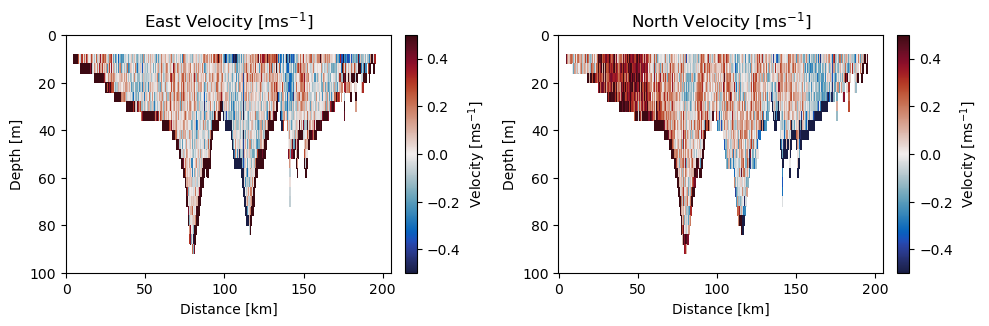

In [475]:
# Plot velocity contours as fucntion of distance and depth
colorBarRange = [-.5, .5]
fig, ax = plt.subplots(figsize=[10,6], ncols=2)
fig0 = ax[0].pcolor(dist_km, bins, U.transpose(), cmap = cmo.balance, vmin=colorBarRange[0], vmax=colorBarRange[1])
cb0 = plt.colorbar(fig0 , ax=ax[0], label='Velocity [ms$^{-1}$]', fraction=0.034, pad=0.04)
ax[0].set_ylim(0, 100)
ax[0].invert_yaxis()
ax[0].set(title='East Velocity [ms$^{-1}$]', xlabel='Distance [km]', ylabel='Depth [m]')
ax[0].set_aspect(1.5)

fig1 = ax[1].pcolor(dist_km, bins, V.transpose(), cmap = cmo.balance, vmin=colorBarRange[0], vmax=colorBarRange[1])
cb1 = plt.colorbar(fig1 , ax=ax[1], label='Velocity [ms$^{-1}$]', fraction=0.034, pad=0.04)
ax[1].set_ylim(0, 100)
ax[1].invert_yaxis()
ax[1].set(title='North Velocity [ms$^{-1}$]', xlabel='Distance [km]', ylabel='Depth [m]')
ax[1].set_aspect(1.5)

plt.tight_layout()
plt.show()

In [476]:
# Plot vectors in map
# Adjust depth data for easy plotting
depth = np.floor(bins + 0.05)
print(depth)
U_xr = xr.DataArray(U, coords={'dist': dist_km,'depth': depth}, dims=["dist", "depth"])
V_xr = xr.DataArray(V, coords={'dist': dist_km,'depth': depth}, dims=["dist", "depth"])

[ 10.  14.  18.  22.  26.  30.  34.  38.  42.  46.  50.  54.  58.  62.
  66.  70.  74.  78.  82.  86.  90.  94.  98. 102. 106. 110. 114. 118.
 122. 126. 130. 134. 138. 142. 146. 150. 154. 158. 162. 166. 170. 174.
 178. 182. 186. 190. 194. 198. 202. 206. 210. 214. 218. 222. 226.]


In [477]:
# Read Bathymetry File
file2read = netcdf.NetCDFFile('ADCP_PP/gebco_2022_n60.0_s54.0_w7.5_e15.0.nc','r')
temp = file2read.variables['lat'] # var can be 'Theta', 'S', 'V', 'U' etc..
bat_lat = temp[:]*1
temp = file2read.variables['lon'] # var can be 'Theta', 'S', 'V', 'U' etc..
bat_lon = temp[:]*1
temp = file2read.variables['elevation'] # var can be 'Theta', 'S', 'V', 'U' etc..
bat_elev = temp[:]*1
file2read.close()

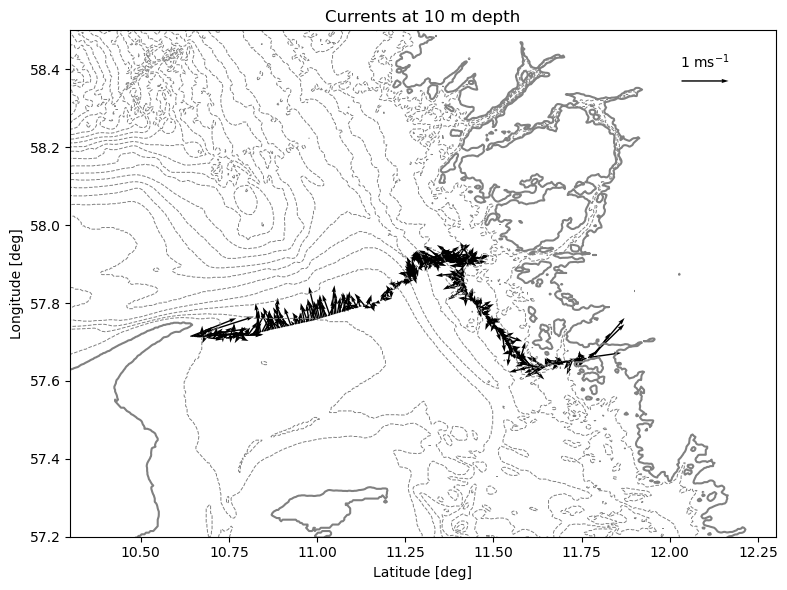

In [478]:
depth_level = 10
fig, ax2 = plt.subplots(1, 1, figsize=(8, 6))
fig2 = ax2.contour(bat_lon, bat_lat, bat_elev, [0], colors='grey')
fig3 = ax2.contour(bat_lon, bat_lat, bat_elev, np.arange(-500, 0, 20), colors='grey', linewidths=0.7)
# ax2.clabel(fig3, fig3.levels, inline=True, fontsize=5)
fig4 = ax2.quiver(lon, lat, U_xr.loc[:,depth_level], V_xr.loc[:,depth_level], scale=15, width = 0.002)
ax2.set_ylim(57.2, 58.5)
ax2.set_xlim(10.3, 12.3)
ax2.set(title='Currents at ' + str(depth_level) + ' m depth', xlabel='Latitude [deg]', ylabel='Longitude [deg]')
ax2.quiverkey(fig4, 0.9, 0.9, 1, '1 ms$^{-1}$', coordinates='axes')

plt.tight_layout()
plt.show()

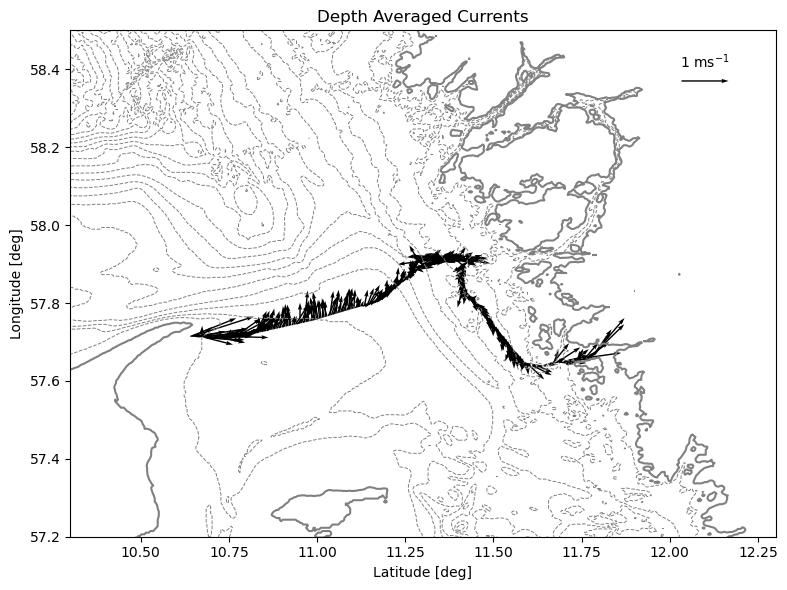

In [479]:
# Depth averaged currents
Umean = np.nanmean(U, 1)
Vmean = np.nanmean(V, 1)

fig, ax3 = plt.subplots(1, 1, figsize=(8, 6))
fig5 = ax3.contour(bat_lon, bat_lat, bat_elev, [0], colors='grey')
fig6 = ax3.contour(bat_lon, bat_lat, bat_elev, np.arange(-500, 0, 20), colors='grey', linewidths=0.7)
# ax2.clabel(fig3, fig3.levels, inline=True, fontsize=5)
fig7 = ax3.quiver(lon, lat, Umean, Vmean, scale=15, width = 0.002)
ax3.set_ylim(57.2, 58.5)
ax3.set_xlim(10.3, 12.3)
ax3.set(title='Depth Averaged Currents', xlabel='Latitude [deg]', ylabel='Longitude [deg]')
ax3.quiverkey(fig7, 0.9, 0.9, 1, '1 ms$^{-1}$', coordinates='axes')

plt.tight_layout()
plt.show()